In [1]:
import xml.etree.ElementTree as ET
import re
import sys
import numpy as np
from svg.path import parse_path
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import matplotlib.animation as animation
from tqdm import tqdm
# import ipywidgets as widgets

In [2]:
filename = input("Enter input filename (with extension)\n")

In [3]:
filename = './' + filename

In [4]:
N = input("Enter number of sample points (optional, default 200)\n")

In [5]:
if N == '':
    N = 200
else:
    N = int(N)

In [6]:
out = input("Enter output filename (optional)\n")

In [7]:
if out == '':
    out = '.'.join([filename[:-4], 'mp4'])

In [8]:
out = './'+out

 99%|█████████▉| 147/148 [00:12<00:00, 11.53it/s]


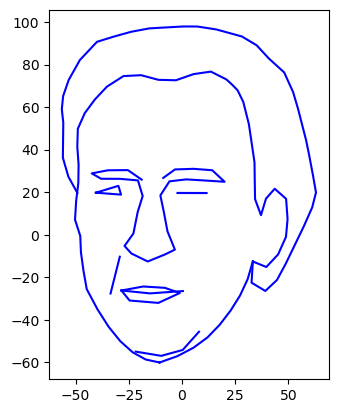

In [9]:
# list of bezier curves
cur = list()

# import svg data
tree = ET.parse(filename)
root = tree.getroot()

# get dimensions for centering
# remove unit and convert to float
h = float(re.sub('[^0-9]', '', root.attrib["height"]))
w = float(re.sub('[^0-9]', '', root.attrib["width"]))

# loop through paths and get lengths
len_list = list()  # store lengths
path_list = list()  # store paths
for child in root.findall(".//{http://www.w3.org/2000/svg}g"):  # find g tags
    for p in child.findall(".//{http://www.w3.org/2000/svg}path"):  # get paths
        tp = parse_path(p.attrib["d"])  # parse paths

        path_length = tp.length()  # get length of current path

        len_list.append(path_length)
        path_list.append(tp)

max_path_length = max(len_list)

# extract paths
for i, tp in enumerate(path_list):
        dc = list()  # instantiate list of discrete points for sampling

        M = int(N * len_list[i] / max_path_length)  # scale number of points according to length

        # discretise path according to length
        for i in np.linspace(0, 1, M):
            dc.append(tp.point(i) - w / 2 - (h / 2)
                      * 1j)  # discretise and recenter
        # for i in range(0, N + 1):
        #     dc.append(tp.point(i / N) - w / 2 - (h / 2)
        #               * 1j)  # discretise and recenter

        # convert discrete curve to np array and append to cur
        cur.append(np.array(dc).conj()) 

# get params for DFT and epicycle drawing


def compute_epi(Z, N):
    DFT = np.fft.fft(Z, n=N) / N  # DFT of data
    k = np.arange(0, N)  # circle frequencies
    r = np.abs(DFT)  # circle radii
    phase = np.angle(DFT)  # initial circle phases

    # sort by descending radius
    idx = r.argsort(kind='stable')  # indices if r sorted ascending
    r = r[idx][::-1]  # sort r and reverse
    k = k[idx][::-1]  # sort k and reverse
    phase = phase[idx][::-1]  # type: ignore # sort and reverse
    DFT = DFT[idx][::-1]  # sort and reverse

    return {'DFT': DFT, 'radii': r, 'frequency': k, 'phase': phase}

# matplotlib animation lib method
cycle_data = list()
frame_data = list()  # list to be passed to animation fn.
for i, c in enumerate(cur):
    M = len(c)  # number of sample points
    cycle_data.append(compute_epi(c, M))  # append returned dict

    frame_data.extend([i] * M)  # add M copies of curve index to frame_data

comp = cycle_data[0]

ts = 2 * np.pi / comp['DFT'].shape[0]

# draw result
time = 0

wavex = list()
wavey = list()

fig = plt.figure()
ax = plt.axes()

ax.set_xlim(-w/2, w/2)
ax.set_ylim(-h/2, h/2)
ax.axis('scaled')

# list of artists
linel = list()
for _ in len_list:  # loop through number of curves
    lin,  = ax.plot([], [])
    linel.append(lin)  # append new line plot artist object

xp = list()  # previous x
yp = list()

current_frame = 0

prev_cur = 0

final_flag = False

def drawnext(i):

    global wavex, wavey, comp, xp, yp, current_frame, prev_cur, final_flag

    if i == -1:  # insert extra frames of completed lineart
        ax.clear()
        if final_flag == False:
            xp.append(wavex.copy())
            yp.append(wavey.copy())
            final_flag = True
        for j, prev in enumerate(xp):
            plt.plot(prev, yp[j], '-b')
        return linel

    if prev_cur != i:
        comp = cycle_data[i]  # get current curve's epicycle data
        xp.append(wavex.copy())
        yp.append(wavey.copy())
        wavex = list()
        wavey = list()
        prev_cur = i
        current_frame = 0

    # compute coords
    k = comp['frequency']
    A = comp['radii']
    time = current_frame * 2 * np.pi / len(cur[i])
    phase = comp['phase']

    x = 0
    y = 0
    N = k.shape[0]
    centres = np.zeros((N, 2))
    lines = np.zeros((N, 4))

    for j in range(0, N):
        # store previous coords for new circle centre
        px = x
        py = y

        # get new joint point coords
        x += A[j] * np.cos(k[j] * time + phase[j])
        y += A[j] * np.sin(k[j] * time + phase[j])

        # circle centres
        centres[j, 0] = px
        centres[j, 1] = py

        # radii lines
        lines[j, :] = np.array([px, x, py, y])

    ax.clear()
    ax.set_xlim(-w/2, w/2)
    ax.set_ylim(-h/2, h/2)
    ax.axis('scaled')

    wavex.append(x)
    wavey.append(y)

    for j in range(N):
        ax.add_artist(
            Circle(
                (centres[j, 0], centres[j, 1]), 
                radius=A[j], color='k', fill=False)
                )

        ax.plot(lines[j, 0:2], lines[j, 2:4], color='k')

        ax.plot(wavex, wavey, '-b')

    ax.plot(x, y, 'or')

    for j, prev in enumerate(xp):
        plt.plot(prev, yp[j], '-b')

    current_frame += 1

    return linel


def init_func():
    global h, w
    ax.set_xlim(-w/2, w/2)
    ax.set_ylim(-h/2, h/2)
    ax.axis('scaled')
    return linel

# add extra frames at end of final drawing
for k in range(0, int(N/4)):
    frame_data.append(-1)

ani = animation.FuncAnimation(
    fig, drawnext, init_func=init_func, interval=100 * (100/N) / 2.4,
    frames=tqdm(frame_data), repeat=False, blit=False)


ani.save(out)